In [1]:
import biom
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as ss
from skbio.stats.composition import clr
from sklearn.metrics import balanced_accuracy_score, make_scorer, log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_validate, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

from helper import tool_text_styling_dict, tool_palette

plt.style.use("./paper.mplstyle")

In [2]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

md = pd.read_table("../data/tcga_reanalyzed/processed/processed_md.tsv", sep="\t", index_col=0)
md["investigation"] = md["investigation"].str.replace("TCGA-", "")
investigations = [x for x in md["investigation"].value_counts().index if x != "BRCA"]
print(md.shape)
invest_labels = pd.Series(
    LabelEncoder().fit_transform(md["investigation"]),
    index=md.index
)
center_labels = pd.Series(
    LabelEncoder().fit_transform(md["data_submitting_center_label"]),
    index=md.index
)

(664, 38)


In [3]:
md["data_submitting_center_label"].value_counts()

Harvard Medical School                                274
Washington University School of Medicine              162
MD Anderson - Institute for Applied Cancer Science    111
Baylor College of Medicine                             65
Broad Institute of MIT and Harvard                     52
Name: data_submitting_center_label, dtype: int64

In [4]:
md.columns

Index(['sample_name', 'run_prefix', 'experimental_strategy', 'cgc_base_name',
       'filename', 'analyte_amount', 'analyte_A260A280Ratio',
       'aliquot_concentration', 'cgc_id', 'cgc_filename', 'vital_status',
       'gender', 'race', 'ethnicity', 'disease_type', 'data_subtype',
       'tcga_sample_id', 'cgc_case_uuid', 'sample_type', 'cgc_platform',
       'gdc_file_uuid', 'primary_site', 'age_at_diagnosis', 'cgc_sample_uuid',
       'cgc_aliquot_uuid', 'tcga_aliquot_id', 'reference_genome',
       'tcga_case_id', 'investigation', 'days_to_death',
       'data_submitting_center_label', 'tissue_source_site_label',
       'country_of_sample_procurement', 'portion_is_ffpe',
       'pathologic_t_label', 'pathologic_n_label',
       'histological_diagnosis_label', 'pathologic_stage_label'],
      dtype='object')

In [5]:
centers_short_map = {
    "Washington University School of Medicine": "WUSTL",
    "Broad Institute of MIT and Harvard": "BI",
    "Baylor College of Medicine": "BCM",
    "Harvard Medical School": "HMS",
    "MD Anderson - Institute for Applied Cancer Science": "MDA"
}

In [6]:
centers = md["data_submitting_center_label"].unique()

center_pal = dict(zip(
    centers,
    sns.color_palette("colorblind", len(centers))
))

In [7]:
from pathlib import Path

qpath = Path("../results/tcga_reanalyzed/")
qfiles = qpath.glob("feature_quantiles.split_*.tsv")
qdict = dict()

for f in qfiles:
    split_num = int(f.name[-5])
    qdict[split_num] = pd.read_table(f, sep="\t")

In [8]:
dpath = Path("../data/tcga_reanalyzed/processed/")
split_dirs = dpath.glob("split_*")

tbl_dict = dict()

for f in split_dirs:
    split_num = int(f.name[-1])
    train_tbl = biom.load_table(f / f"merged_tbl.train.{split_num}.biom")
    valid_tbl = biom.load_table(f / f"merged_tbl.valid.{split_num}.biom")
    tbl_dict[split_num] = {"train": train_tbl, "valid": valid_tbl}

In [9]:
test_tbl = biom.load_table(dpath / "merged_tbl.test.biom")

In [10]:
model = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=5000,
    class_weight="balanced",
    fit_intercept=True,
    C=1
)

In [11]:
def log_ratio(table, top_feats, bot_feats):
    num_sum = table.loc[:, top_feats].sum(axis=1)
    denom_sum = table.loc[:, bot_feats].sum(axis=1)
    lr_df = pd.concat([num_sum, denom_sum], axis=1)
    lr_df.columns = ["num", "denom"]
    #lr_df = lr_df.dropna(how="all")
    lr_df = lr_df + 1
    lr_df["log_ratio"] = np.log(lr_df["num"]/lr_df["denom"]).to_frame()
    return lr_df

In [12]:
def get_lr_feats(quantiles, invest, n=50):
    top_n = quantiles.query("quantile == 0.975").sort_values(by=invest)["feature"].tail(n).values
    bot_n = quantiles.query("quantile == 0.025").sort_values(by=invest)["feature"].head(n).values
    
    return top_n, bot_n

In [13]:
def get_lr_feats_other(results_df, invest, n=50):
    col = results_df[invest].sort_values(ascending=False)
    top_n = col.head(n).index
    bot_n = col.tail(n).index

    return top_n, bot_n

In [14]:
def get_predictor_df(tbl, top_feats, bot_feats):
    tbl_df = tbl.to_dataframe(dense=True).T
    lr = log_ratio(tbl_df, top_n, bot_n)["log_ratio"]

    return lr

# BIRDMAn

In [15]:
from collections import defaultdict
from copy import deepcopy

best_birdman_score = 0
birdman_score_dict = dict()

for i in range(5):
    train_tbl = tbl_dict[i]["train"]
    valid_tbl = tbl_dict[i]["valid"]
    quantiles = qdict[i]
    
    train_predictors = dict()
    valid_predictors = dict()
    
    ratio_microbes = dict()
    
    for invest in investigations:
        top_n, bot_n = get_lr_feats(quantiles, invest, n=100)
        train_predictors[invest] = get_predictor_df(train_tbl, top_n, bot_n)
        valid_predictors[invest] = get_predictor_df(valid_tbl, top_n, bot_n)
        ratio_microbes[invest] = {"top": top_n, "bot": bot_n}

    predictor_df_train = (
        pd.DataFrame.from_dict(train_predictors)
        .join(md[["investigation", "data_submitting_center_label"]], how="inner")
    )
    predictor_df_valid = (
        pd.DataFrame.from_dict(valid_predictors)
        .join(md[["investigation", "data_submitting_center_label"]], how="inner")
    )

    X_train = predictor_df_train[investigations]
    _invests = predictor_df_train["investigation"].unique()
    _invests = [x for x in _invests if x != "BRCA"]
    X_train = X_train[_invests]
    
    transformer = LabelEncoder().fit(predictor_df_train["investigation"])
    y_train = transformer.transform(predictor_df_train["investigation"])

    model.fit(X_train, y_train)
    
    X_valid = predictor_df_valid[investigations]
    _invests = predictor_df_valid["investigation"].unique()
    _invests = [x for x in _invests if x != "BRCA"]
    X_valid = X_valid[_invests]
    y_valid = transformer.transform(predictor_df_valid["investigation"])
    
    train_score = model.score(X_train, y_train)
    valid_score = model.score(X_valid, y_valid)
    
    print(f"Split {i}: Train={train_score:.3f}, Valid={valid_score:.3f}")
    
    if valid_score > best_birdman_score:
        best_birdman_quantiles = quantiles
        best_birdman_model = deepcopy(model)
        best_birdman_score = valid_score
        best_transformer = transformer
        best_birdman_ratio_microbes = ratio_microbes
        
    birdman_score_dict[i] = {"train": train_score, "valid": valid_score}

Split 0: Train=0.741, Valid=0.748
Split 1: Train=0.793, Valid=0.745
Split 2: Train=0.821, Valid=0.774
Split 3: Train=0.753, Valid=0.726
Split 4: Train=0.736, Valid=0.708


In [16]:
birdman_scores = pd.DataFrame(birdman_score_dict).T
birdman_scores["tool"] = "BIRDMAn"
birdman_scores

,train,valid,tool
0,0.740566,0.747664,BIRDMAn
1,0.792941,0.745283,BIRDMAn
2,0.821176,0.773585,BIRDMAn
3,0.752941,0.726415,BIRDMAn
4,0.736471,0.707547,BIRDMAn


In [17]:
test_predictors = dict()

for invest in investigations:
    top_n, bot_n = get_lr_feats(best_birdman_quantiles, invest, n=100)
    test_predictors[invest] = get_predictor_df(test_tbl, top_n, bot_n)

predictor_df_test = (
    pd.DataFrame.from_dict(test_predictors)
    .join(md[["investigation", "data_submitting_center_label"]], how="inner")
)

X_test = predictor_df_test[investigations]
_invests = predictor_df_test["investigation"].unique()
_invests = [x for x in _invests if x != "BRCA"]
X_test = X_test[_invests]
y_test = best_transformer.transform(predictor_df_test["investigation"])

test_birdman_score = best_birdman_model.score(X_test, y_test)
print(test_birdman_score)

0.8120300751879699


# Other Tools

## ALDEx2

In [18]:
import re

aldex2_regex = re.compile("model\.investigation([A-Z]+) Estimate")
aldex2_path = Path("../results/tcga_reanalyzed/aldex2_split/")

best_aldex2_score = 0
aldex2_score_dict = dict()

for i in range(5):
    train_tbl = tbl_dict[i]["train"]
    valid_tbl = tbl_dict[i]["valid"]
    
    aldex2_split_path = aldex2_path / f"split_{i}.results.tsv"
    aldex2_res = pd.read_table(aldex2_split_path, sep="\t", index_col=0)
    cols = [x for x in aldex2_res.columns if "investigation" in x]
    aldex2_res = aldex2_res[cols]
    aldex2_res = aldex2_res.filter(like="Estimate")
    aldex2_res = aldex2_res.rename(columns=lambda x: aldex2_regex.search(x).groups()[0])
    
    train_predictors = dict()
    valid_predictors = dict()
    
    for invest in investigations:
        top_n, bot_n = get_lr_feats_other(aldex2_res, invest, n=100)
        train_predictors[invest] = get_predictor_df(train_tbl, top_n, bot_n)
        valid_predictors[invest] = get_predictor_df(valid_tbl, top_n, bot_n)
    
    predictor_df_train = (
        pd.DataFrame.from_dict(train_predictors)
        .join(md[["investigation", "data_submitting_center_label"]], how="inner")
    )
    predictor_df_valid = (
        pd.DataFrame.from_dict(valid_predictors)
        .join(md[["investigation", "data_submitting_center_label"]], how="inner")
    )

    X_train = predictor_df_train[investigations]
    _invests = predictor_df_train["investigation"].unique()
    _invests = [x for x in _invests if x != "BRCA"]
    X_train = X_train[_invests]
    
    transformer = LabelEncoder().fit(predictor_df_train["investigation"])
    y_train = transformer.transform(predictor_df_train["investigation"])

    model.fit(X_train, y_train)
    
    X_valid = predictor_df_valid[investigations]
    _invests = predictor_df_valid["investigation"].unique()
    _invests = [x for x in _invests if x != "BRCA"]
    X_valid = X_valid[_invests]
    y_valid = transformer.transform(predictor_df_valid["investigation"])
    
    train_score = model.score(X_train, y_train)
    valid_score = model.score(X_valid, y_valid)
    
    print(f"Split {i}: Train={train_score:.3f}, Valid={valid_score:.3f}")
    
    if valid_score > best_aldex2_score:
        best_aldex2_res = aldex2_res
        best_aldex2_model = deepcopy(model)
        best_aldex2_score = valid_score
        best_aldex2_transformer = transformer
        
    aldex2_score_dict[i] = {"train": train_score, "valid": valid_score}

Split 0: Train=0.559, Valid=0.542
Split 1: Train=0.562, Valid=0.509
Split 2: Train=0.471, Valid=0.443
Split 3: Train=0.478, Valid=0.509
Split 4: Train=0.478, Valid=0.509


In [19]:
aldex2_scores = pd.DataFrame(aldex2_score_dict).T
aldex2_scores["tool"] = "ALDEx2"
aldex2_scores

,train,valid,tool
0,0.558962,0.542056,ALDEx2
1,0.562353,0.509434,ALDEx2
2,0.470588,0.443396,ALDEx2
3,0.477647,0.509434,ALDEx2
4,0.477647,0.509434,ALDEx2


In [20]:
test_predictors = dict()

for invest in investigations:
    top_n, bot_n = get_lr_feats_other(best_aldex2_res, invest, n=100)
    test_predictors[invest] = get_predictor_df(test_tbl, top_n, bot_n)

predictor_df_test = (
    pd.DataFrame.from_dict(test_predictors)
    .join(md[["investigation", "data_submitting_center_label"]], how="inner")
)

X_test = predictor_df_test[investigations]
_invests = predictor_df_test["investigation"].unique()
_invests = [x for x in _invests if x != "BRCA"]
X_test = X_test[_invests]
y_test = best_aldex2_transformer.transform(predictor_df_test["investigation"])

test_aldex2_score = best_aldex2_model.score(X_test, y_test)
print(test_aldex2_score)

0.5864661654135338


## ANCOMBC

In [21]:
ancombc_path = Path("../results/tcga_reanalyzed/ancombc_split/")

best_ancombc_score = 0

ancombc_score_dict = dict()

for i in range(5):
    train_tbl = tbl_dict[i]["train"]
    valid_tbl = tbl_dict[i]["valid"]
    
    ancombc_split_path = ancombc_path / f"split_{i}.results.beta.tsv"
    ancombc_res = pd.read_table(ancombc_split_path, sep="\t", index_col=0)
    ancombc_res = ancombc_res.filter(like="investigation")
    ancombc_res.columns = [x.replace("investigation", "") for x in ancombc_res.columns]
    
    train_predictors = dict()
    valid_predictors = dict()
    
    for invest in investigations:
        top_n, bot_n = get_lr_feats_other(ancombc_res, invest, n=100)
        train_predictors[invest] = get_predictor_df(train_tbl, top_n, bot_n)
        valid_predictors[invest] = get_predictor_df(valid_tbl, top_n, bot_n)
    
    predictor_df_train = (
        pd.DataFrame.from_dict(train_predictors)
        .join(md[["investigation", "data_submitting_center_label"]], how="inner")
    )
    predictor_df_valid = (
        pd.DataFrame.from_dict(valid_predictors)
        .join(md[["investigation", "data_submitting_center_label"]], how="inner")
    )

    X_train = predictor_df_train[investigations]
    _invests = predictor_df_train["investigation"].unique()
    _invests = [x for x in _invests if x != "BRCA"]
    X_train = X_train[_invests]
    
    transformer = LabelEncoder().fit(predictor_df_train["investigation"])
    y_train = transformer.transform(predictor_df_train["investigation"])

    model.fit(X_train, y_train)
    
    X_valid = predictor_df_valid[investigations]
    _invests = predictor_df_valid["investigation"].unique()
    _invests = [x for x in _invests if x != "BRCA"]
    X_valid = X_valid[_invests]
    y_valid = transformer.transform(predictor_df_valid["investigation"])
    
    train_score = model.score(X_train, y_train)
    valid_score = model.score(X_valid, y_valid)
    
    print(f"Split {i}: Train={train_score:.3f}, Valid={valid_score:.3f}")
    
    if valid_score > best_ancombc_score:
        best_ancombc_res = ancombc_res
        best_ancombc_model = deepcopy(model)
        best_ancombc_score = valid_score
        best_ancombc_transformer = transformer
        
    ancombc_score_dict[i] = {"train": train_score, "valid": valid_score}

Split 0: Train=0.467, Valid=0.467
Split 1: Train=0.475, Valid=0.396
Split 2: Train=0.459, Valid=0.462
Split 3: Train=0.454, Valid=0.472
Split 4: Train=0.456, Valid=0.509


In [22]:
ancombc_scores = pd.DataFrame(ancombc_score_dict).T
ancombc_scores["tool"] = "ANCOM-BC"
ancombc_scores

,train,valid,tool
0,0.466981,0.467290,ANCOM-BC
1,0.475294,0.396226,ANCOM-BC
2,0.458824,0.462264,ANCOM-BC
3,0.454118,0.471698,ANCOM-BC
4,0.456471,0.509434,ANCOM-BC


In [23]:
test_predictors = dict()

for invest in investigations:
    top_n, bot_n = get_lr_feats_other(best_ancombc_res, invest, n=100)
    test_predictors[invest] = get_predictor_df(test_tbl, top_n, bot_n)

predictor_df_test = (
    pd.DataFrame.from_dict(test_predictors)
    .join(md[["investigation", "data_submitting_center_label"]], how="inner")
)

X_test = predictor_df_test[investigations]
_invests = predictor_df_test["investigation"].unique()
_invests = [x for x in _invests if x != "BRCA"]
X_test = X_test[_invests]
y_test = best_ancombc_transformer.transform(predictor_df_test["investigation"])

test_ancombc_score = best_ancombc_model.score(X_test, y_test)
print(test_ancombc_score)

0.5112781954887218


## DESeq2

In [24]:
deseq2_path = Path("../results/tcga_reanalyzed/deseq2_split/")

best_deseq2_score = 0

deseq2_score_dict = dict()


for i in range(5):
    train_tbl = tbl_dict[i]["train"]
    valid_tbl = tbl_dict[i]["valid"]
    
    deseq2_split_path = deseq2_path / f"split_{i}"
    deseq2_invest_files = deseq2_split_path.glob("*.tsv")
    deseq2_dfs = []
    
    for f in deseq2_invest_files:
        invest = f.stem
        if invest == "Intercept":
            continue
        _df = pd.read_table(f, sep="\t", index_col=0)
        _df = _df["log2FoldChange"]
        _df.name = invest
        deseq2_dfs.append(_df)
        
    deseq2_res = pd.concat(deseq2_dfs, axis=1)
    
    train_predictors = dict()
    valid_predictors = dict()
    
    for invest in investigations:
        top_n, bot_n = get_lr_feats_other(deseq2_res, invest, n=100)
        train_predictors[invest] = get_predictor_df(train_tbl, top_n, bot_n)
        valid_predictors[invest] = get_predictor_df(valid_tbl, top_n, bot_n)
    
    predictor_df_train = (
        pd.DataFrame.from_dict(train_predictors)
        .join(md[["investigation", "data_submitting_center_label"]], how="inner")
    )
    predictor_df_valid = (
        pd.DataFrame.from_dict(valid_predictors)
        .join(md[["investigation", "data_submitting_center_label"]], how="inner")
    )

    X_train = predictor_df_train[investigations]
    _invests = predictor_df_train["investigation"].unique()
    _invests = [x for x in _invests if x != "BRCA"]
    X_train = X_train[_invests]
    
    transformer = LabelEncoder().fit(predictor_df_train["investigation"])
    y_train = transformer.transform(predictor_df_train["investigation"])

    model.fit(X_train, y_train)
    
    X_valid = predictor_df_valid[investigations]
    _invests = predictor_df_valid["investigation"].unique()
    _invests = [x for x in _invests if x != "BRCA"]
    X_valid = X_valid[_invests]
    y_valid = transformer.transform(predictor_df_valid["investigation"])
    
    train_score = model.score(X_train, y_train)
    valid_score = model.score(X_valid, y_valid)
    
    print(f"Split {i}: Train={train_score:.3f}, Valid={valid_score:.3f}")
    
    if valid_score > best_deseq2_score:
        best_deseq2_res = deseq2_res
        best_deseq2_model = deepcopy(model)
        best_deseq2_score = valid_score
        best_deseq2_transformer = transformer
        
    deseq2_score_dict[i] = {"train": train_score, "valid": valid_score}

Split 0: Train=0.613, Valid=0.626
Split 1: Train=0.713, Valid=0.651
Split 2: Train=0.529, Valid=0.604
Split 3: Train=0.689, Valid=0.689
Split 4: Train=0.591, Valid=0.594


In [25]:
deseq2_scores = pd.DataFrame(deseq2_score_dict).T
deseq2_scores["tool"] = "DESeq2"
deseq2_scores

,train,valid,tool
0,0.613208,0.626168,DESeq2
1,0.712941,0.650943,DESeq2
2,0.529412,0.603774,DESeq2
3,0.689412,0.688679,DESeq2
4,0.590588,0.594340,DESeq2


In [26]:
test_predictors = dict()

for invest in investigations:
    top_n, bot_n = get_lr_feats_other(best_deseq2_res, invest, n=100)
    test_predictors[invest] = get_predictor_df(test_tbl, top_n, bot_n)

predictor_df_test = (
    pd.DataFrame.from_dict(test_predictors)
    .join(md[["investigation", "data_submitting_center_label"]], how="inner")
)

X_test = predictor_df_test[investigations]
_invests = predictor_df_test["investigation"].unique()
_invests = [x for x in _invests if x != "BRCA"]
X_test = X_test[_invests]
y_test = best_deseq2_transformer.transform(predictor_df_test["investigation"])

test_deseq2_score = best_deseq2_model.score(X_test, y_test)
print(test_deseq2_score)

0.6691729323308271


## Songbird

In [27]:
songbird_regex = re.compile("\[T.TCGA-(\w+)\]")
songbird_path = Path("../results/tcga_reanalyzed/songbird_split/")

best_sbird_score = 0

songbird_score_dict = dict()

for i in range(5):
    train_tbl = tbl_dict[i]["train"]
    valid_tbl = tbl_dict[i]["valid"]
    
    songbird_split_path = songbird_path / f"split_{i}" / "differentials.tsv"
    songbird_res = pd.read_table(songbird_split_path, index_col=0)
    songbird_res = songbird_res.filter(like="investigation")
    songbird_res.columns = [
        songbird_regex.search(x).groups()[0] for x in songbird_res.columns
        if "investigation" in x
    ]

    train_predictors = dict()
    valid_predictors = dict()
    
    for invest in investigations:
        top_n, bot_n = get_lr_feats_other(songbird_res, invest, n=100)
        train_predictors[invest] = get_predictor_df(train_tbl, top_n, bot_n)
        valid_predictors[invest] = get_predictor_df(valid_tbl, top_n, bot_n)
    
    predictor_df_train = (
        pd.DataFrame.from_dict(train_predictors)
        .join(md[["investigation", "data_submitting_center_label"]], how="inner")
    )
    predictor_df_valid = (
        pd.DataFrame.from_dict(valid_predictors)
        .join(md[["investigation", "data_submitting_center_label"]], how="inner")
    )

    X_train = predictor_df_train[investigations]
    _invests = predictor_df_train["investigation"].unique()
    _invests = [x for x in _invests if x != "BRCA"]
    X_train = X_train[_invests]
    
    transformer = LabelEncoder().fit(predictor_df_train["investigation"])
    y_train = transformer.transform(predictor_df_train["investigation"])

    model.fit(X_train, y_train)
    
    X_valid = predictor_df_valid[investigations]
    _invests = predictor_df_valid["investigation"].unique()
    _invests = [x for x in _invests if x != "BRCA"]
    X_valid = X_valid[_invests]
    y_valid = transformer.transform(predictor_df_valid["investigation"])
    
    train_score = model.score(X_train, y_train)
    valid_score = model.score(X_valid, y_valid)
    
    print(f"Split {i}: Train={train_score:.3f}, Valid={valid_score:.3f}")
    
    if valid_score > best_sbird_score:
        best_sbird_res = songbird_res
        best_sbird_model = deepcopy(model)
        best_sbird_score = valid_score
        best_sbird_transformer = transformer
        
    songbird_score_dict[i] = {"train": train_score, "valid": valid_score}

Split 0: Train=0.616, Valid=0.617
Split 1: Train=0.680, Valid=0.547
Split 2: Train=0.633, Valid=0.708
Split 3: Train=0.631, Valid=0.651
Split 4: Train=0.645, Valid=0.604


In [28]:
songbird_scores = pd.DataFrame(songbird_score_dict).T
songbird_scores["tool"] = "Songbird"
songbird_scores

,train,valid,tool
0,0.615566,0.616822,Songbird
1,0.680000,0.547170,Songbird
2,0.632941,0.707547,Songbird
3,0.630588,0.650943,Songbird
4,0.644706,0.603774,Songbird


In [29]:
test_predictors = dict()

for invest in investigations:
    top_n, bot_n = get_lr_feats_other(best_sbird_res, invest, n=100)
    test_predictors[invest] = get_predictor_df(test_tbl, top_n, bot_n)

predictor_df_test = (
    pd.DataFrame.from_dict(test_predictors)
    .join(md[["investigation", "data_submitting_center_label"]], how="inner")
)

X_test = predictor_df_test[investigations]
_invests = predictor_df_test["investigation"].unique()
_invests = [x for x in _invests if x != "BRCA"]
X_test = X_test[_invests]
y_test = best_sbird_transformer.transform(predictor_df_test["investigation"])

test_sbird_score = best_sbird_model.score(X_test, y_test)
print(test_sbird_score)

0.6390977443609023


## Random Forest

In [30]:
def tbl_to_clr(tbl):
    tbl_df = tbl.to_dataframe(dense=True).T
    return pd.DataFrame(clr(tbl_df.values + 1), index=tbl_df.index, columns=tbl_df.columns)

In [31]:
rf_model = RandomForestClassifier(random_state=63, n_estimators=100)

In [32]:
best_rf_score = 0

rf_score_dict = dict()

for i in range(5):
    train_tbl = tbl_to_clr(tbl_dict[i]["train"]).join(md["investigation"])
    valid_tbl = tbl_to_clr(tbl_dict[i]["valid"]).join(md["investigation"])
    
    transformer = LabelEncoder().fit(train_tbl["investigation"])
    y_train = transformer.transform(train_tbl["investigation"])
    X_train = train_tbl.drop(columns=["investigation"]).values
    
    y_valid = transformer.transform(valid_tbl["investigation"])
    X_valid = valid_tbl.drop(columns=["investigation"]).values
    
    rf_model.fit(X_train, y_train)
    
    train_score = rf_model.score(X_train, y_train)
    valid_score = rf_model.score(X_valid, y_valid)
    
    print(f"Split {i}: Train={train_score:.3f}, Valid={valid_score:.3f}")
    
    if valid_score > best_rf_score:
        best_rf_model = deepcopy(rf_model)
        best_rf_transformer = transformer
        
    rf_score_dict[i] = {"train": train_score, "valid": valid_score}

Split 0: Train=1.000, Valid=0.785
Split 1: Train=1.000, Valid=0.792
Split 2: Train=1.000, Valid=0.849
Split 3: Train=1.000, Valid=0.877
Split 4: Train=1.000, Valid=0.887


In [33]:
rf_scores = pd.DataFrame(rf_score_dict).T
rf_scores["tool"] = "Random Forest"
rf_scores

,train,valid,tool
0,1.0,0.785047,Random Forest
1,1.0,0.792453,Random Forest
2,1.0,0.849057,Random Forest
3,1.0,0.877358,Random Forest
4,1.0,0.886792,Random Forest


In [34]:
X_test = tbl_to_clr(test_tbl).join(md["investigation"])
y_test = best_rf_transformer.transform(X_test["investigation"])
X_test = X_test.drop(columns=["investigation"])

test_rf_score = best_rf_model.score(X_test, y_test)

/home/grahman/miniconda3/envs/birdman-analyses-final/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [35]:
score_df = pd.concat([
    birdman_scores,
    aldex2_scores,
    ancombc_scores,
    deseq2_scores,
    songbird_scores,
    rf_scores
])

test_scores = [
    test_birdman_score,
    test_aldex2_score,
    test_ancombc_score,
    test_deseq2_score,
    test_sbird_score,
    test_rf_score
]

score_df = score_df.melt(value_vars=["train", "valid"], id_vars=["tool"])
score_df["variable"] = score_df["variable"].str.capitalize()
score_df.head()

,tool,variable,value
0,BIRDMAn,Train,0.740566
1,BIRDMAn,Train,0.792941
2,BIRDMAn,Train,0.821176
3,BIRDMAn,Train,0.752941
4,BIRDMAn,Train,0.736471


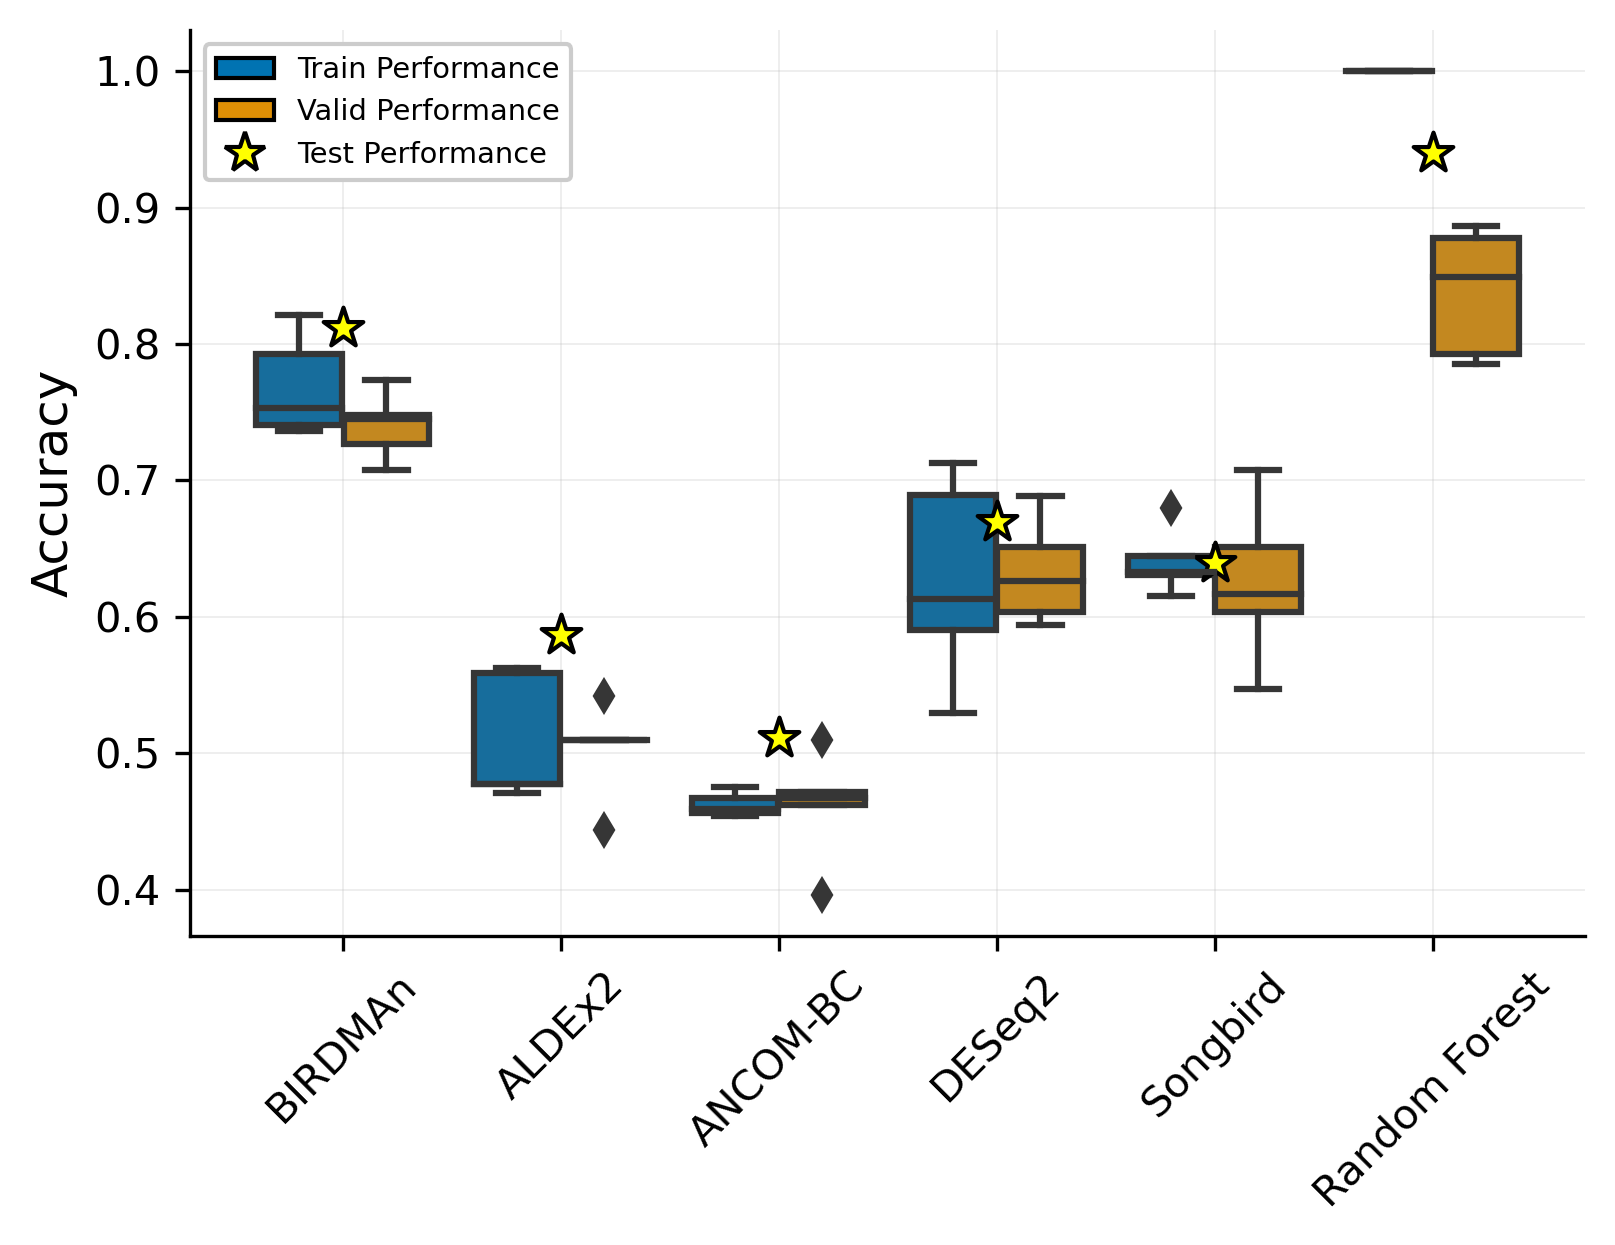

In [36]:
fig, ax = plt.subplots(1, 1)

cmap = dict(zip(["Train", "Valid"], sns.color_palette("colorblind", 2)))

sns.boxplot(
    data=score_df,
    x="tool",
    y="value",
    hue="variable",
    palette=cmap,
    ax=ax
)

for i, _score in enumerate(test_scores):
    ax.scatter(
        [i],
        [_score],
        marker="*",
        edgecolor="black",
        color="yellow",
        s=100
    )
    ax.tick_params("x", rotation=45)
    
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

handles = [
    Patch(facecolor=c, label=label + " Performance", edgecolor="black")
    for label, c in cmap.items()
]
handles.append(
    Line2D([0], [0], marker="*", mfc="yellow", mec="black", lw=0,
           markersize=10, label="Test Performance")
)

ax.legend(handles=handles, framealpha=1)
ax.set_ylabel("Accuracy")
ax.set_xlabel("")
ax.grid()

plt.savefig("../figures/tcga_reanalyzed/tool_model_perf.pdf")
plt.savefig("../figures/tcga_reanalyzed/tool_model_perf.png")

plt.show()

In [37]:
import json
from copy import deepcopy

with open("./best_birdman_ratio_microbes.json", "w+") as fp:
    _d = deepcopy(best_birdman_ratio_microbes)
    for cancer_type, ratio_dict in _d.items():
        for loc, microbes in ratio_dict.items():
            _d[cancer_type][loc] = microbes.tolist()
    json.dump(_d, fp)

In [41]:
a = set(best_birdman_ratio_microbes["HNSC"]["top"])
b = set(best_birdman_ratio_microbes["HNSC"]["bot"])